<a href="https://colab.research.google.com/github/progmem64/lego-brick-recognition-tensorflow/blob/master/lego_brick_recognition_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init Colab

**storage info:**

download files instead of mounting google drive as google drive latency and throughput while deferred read in is really slow

In [1]:
%cd "/content"
!ls
!git clone https://github.com/progmem64/lego-brick-recognition-tensorflow

/content
drive  sample_data
Cloning into 'lego-brick-recognition-tensorflow'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 9226 (delta 0), reused 0 (delta 0), pack-reused 9223
Receiving objects: 100% (9226/9226), 363.37 MiB | 41.46 MiB/s, done.
Checking out files: 100% (9178/9178), done.


In [2]:
%cd "/content/lego-brick-recognition-tensorflow"
!ls
!git pull

!mkdir -p "/content/lego-brick-recognition-tensorflow/model"

/content/lego-brick-recognition-tensorflow
data  example  lego_brick_recognition_tensorflow.ipynb	literature  README.md
Already up to date.


# Imports and globals

In [3]:
import tensorflow as tf
import os
import glob
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

print(tf.__version__)

# base_path = "/content/drive/My Drive/lego-brick-recognition-tensorflow"
base_path = "/content/lego-brick-recognition-tensorflow"
data_path = base_path + "/data"
model_path = base_path + "/model"

print(data_path)

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)


2.2.0
/content/lego-brick-recognition-tensorflow/data


## Enable GPU

In [4]:
# tf.debugging.set_log_device_placement(True)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=ae9ec142ffde2178df6e10c6d201d4a8030de1a07756ded632f77a70cca0baf4
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.1 GB  | Proc size: 1.1 GB
GPU RAM Free: 14860MB | Used: 219MB | Util   1% | Total 15079MB


## Enable TPU

In [0]:
%%script false
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

# Prepare dataset

## read in, creation, split

### read class_names, filenames

In [7]:
# images_path = data_path + "/Cropped Images"
images_path = data_path + "/Base Images"
images_path

'/content/lego-brick-recognition-tensorflow/data/Base Images'

generate class_names from folder structure

In [8]:
class_names = [x.split('/')[-1] for x 
              in glob.glob(images_path + "/*")]
class_names

['Brick_2x2_L',
 'Plate_1x1_Round',
 'Plate_1x3',
 'Brick_1x4',
 'Plate_2x3',
 'Brick_1x1',
 'Plate_1x4',
 'Plate_1x1',
 'Brick_1x3',
 'Brick_2x4',
 'Brick_2x3',
 'Plate_1x2',
 'Brick_2x2',
 'Brick_2x2_Slope',
 'Plate_2x2',
 'Plate_1x1_Slope',
 'Brick_1x2',
 'Plate_1x2_Grill',
 'Plate_2x4',
 'Plate_2x2_L']

get all image files & shuffle them

In [9]:
filenames = np.asarray(
    glob.glob(images_path + "/*/*.jpg"))

# shuffle filenames deterministic
rng = np.random.default_rng(seed)
rng.shuffle(filenames)

ds_size = len(filenames)
print(f'Number of elements: {ds_size}')

print(f'first element: {filenames[0]}')

Number of elements: 4580
first element: /content/lego-brick-recognition-tensorflow/data/Base Images/Brick_1x3/2_Brick_1x3_180709185510.jpg


### split set

60/20/20

In [10]:
train_size = int(0.6 * ds_size)
valid_size = int(0.2 * ds_size)
test_size = ds_size - train_size - valid_size

train_filenames = filenames[:train_size] # 0-60%
valid_filenames = filenames[train_size:-test_size] # 60-80%
test_filenames = filenames[-test_size:] # 80-100%

print(f'train_size: {train_size} {len(train_filenames)}')
print(f'valid_size: {valid_size} {len(valid_filenames)}')
print(f'test_size: {test_size} {len(test_filenames)}')

train_size: 2748 2748
valid_size: 916 916
test_size: 916 916


### approach 1: read files in memory

**pro:**

* works with TPU without using google cloud bucket storage

**cons:**

* does not work as files are to big

`ram_needed = n * px_width * px_height * 3 channels * 32 bit`

* for base images this means:
  * `n = 4580, px_width = 640, px_height = 480`
  * `ram_needed = 16.88 GB` => way too big

In [0]:
%%script false
def load_image(i, filename):
  print(i)
  return tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(filename))

files = np.array([load_image(i, fn) for i, fn in enumerate(filenames)])
print("done loading, size: ", files.nbytes)

### approach 2: dataset with deferred read in

**pro:**

* set size does not matter as data is read in deferred

**cons:**

* does not work with TPU as local storage backend is not supported
* slow while using google drive mount => workaround: download to local file system

In [0]:
def process_image(raw_img):
  img = tf.image.decode_jpeg(raw_img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, [480, 640])
  return img


def get_data_label_pair(filename):
  parts = tf.strings.split(filename, sep='/')
  # tf variant of: class_names.index(parts[-2])
  label = tf.where(parts[-2] == class_names)[0][0]

  img = tf.io.read_file(filename)
  img = process_image(img)
  return img, label


def create_dataset(filenames):
  ds = tf.data.Dataset.from_tensor_slices(filenames)
  ds = ds.map(get_data_label_pair, 
              num_parallel_calls=tf.data.experimental.AUTOTUNE)
  return ds

### create datasets

In [0]:
train_ds = create_dataset(train_filenames)
valid_ds = create_dataset(valid_filenames)
test_ds = create_dataset(test_filenames)

Test `train_ds` read

Image shape:  (480, 640, 3)
Label:  8
Class name:  Brick_1x3


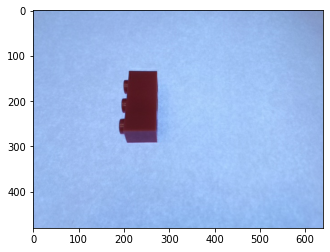

In [14]:
for img, label in train_ds.take(1):
  print("Image shape: ", img.numpy().shape)
  print("Label: ", label.numpy())
  print("Class name: ", class_names[label.numpy()])
  plt.imshow(img)
  plt.show()

### ~Split set after dataset was created~

`ds` must not be reshuffled after each iteration in order for this to work

can be used for cross validation

In [0]:
%%script false
train_size = int(0.6 * ds_size)
valid_size = int(0.2 * ds_size)
test_size = ds_size - train_size - valid_size

train_ds = full_ds.take(train_size) # 0-60%
valid_ds = full_ds.skip(train_size) # 60-100%
valid_ds = valid_ds.take(valid_size) # 60-80%
test_ds = full_ds.skip(train_size + valid_size) # ~80-100%

print(f'train_size: {train_size}')
print(f'valid_size: {valid_size}')
print(f'test_size: {test_size}')

## Test transformations, preprocessing, ...

Test MaxPool2D

Image shape:  (480, 640, 3)
Image shape (new):  (240, 320, 3)
Label:  8
Class name:  Brick_1x3


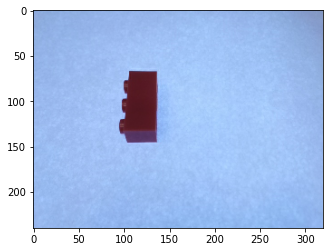

In [16]:
max_pool = tf.keras.layers.MaxPool2D(2)

for img, label in train_ds.take(1):
  imgs = np.array([img.numpy()])
  m = max_pool(imgs)
  print("Image shape: ", img.numpy().shape)
  print("Image shape (new): ", m[0].numpy().shape)
  print("Label: ", label.numpy())
  print("Class name: ", class_names[label.numpy()])
  plt.imshow(m[0])
  plt.show()

Try some image manipulations

Image shape:  (480, 640, 3)
Image shape (new):  (480, 640, 3)
Label:  8
Class name:  Brick_1x3


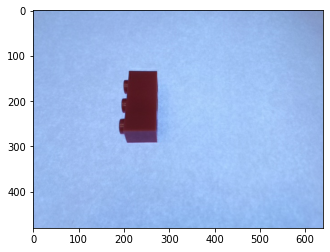

Image shape:  (480, 640, 3)
Image shape (new):  (480, 640, 3)
Label:  6
Class name:  Plate_1x4


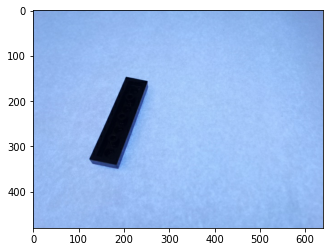

Image shape:  (480, 640, 3)
Image shape (new):  (480, 640, 3)
Label:  18
Class name:  Plate_2x4


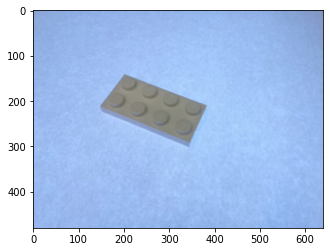

In [17]:
for img, label in train_ds.take(3):
  m = np.array([img.numpy()])
  # m = tf.image.resize(m, [224, 224])
  # m = tf.image.resize_with_crop_or_pad(m, 224, 224)
  # m = tf.image.adjust_brightness(m, delta=.3)
  # m = tf.image.adjust_contrast(m, contrast_factor=1)
  # m = tf.image.adjust_gamma(m, gamma=1.2, gain=2)
  m = tf.clip_by_value(m, 0., 1.)
  print("Image shape: ", img.numpy().shape)
  print("Image shape (new): ", m[0].numpy().shape)
  print("Label: ", label.numpy())
  print("Class name: ", class_names[label.numpy()])
  plt.imshow(m[0])
  plt.show()

# Train model

In [0]:
def prepare_for_training(ds, 
                         batch_size=32, 
                         shuffle_buffer_size=1000):
  # ds.cache() # use prefetch instead => slow
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(
      buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

## first approach

In [0]:
def create_model():
  from tensorflow.keras import layers

  model = tf.keras.Sequential([
    tf.keras.Input((480, 640, 3)),

    layers.Conv2D(filters=32, kernel_size=5, activation='relu'),
    layers.MaxPooling2D(pool_size=2, strides=2),

    layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=2, strides=2),
    
    layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=2, strides=2),

    layers.Conv2D(filters=256, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=2, strides=2),

    layers.Conv2D(filters=512, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=2, strides=2),

    layers.Conv2D(filters=1024, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=2, strides=2),

    layers.Flatten(),
    layers.Dense(units=1024, activation='relu'),
    layers.Dropout(0.5),
    # layers.Dense(units=256, activation='relu'),
    # layers.Dropout(0.5),
    # layers.Dense(units=128, activation='relu'),
    # layers.Dropout(0.5),
    layers.Dense(units=len(class_names), activation='softmax'),
  ])
  
  model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
  return model

                
def train_and_save_model(model):
  batch_size = 16 # too low => slow, too high => risk of OOM
  train_ds_p = prepare_for_training(train_ds, batch_size)
  valid_ds_p = prepare_for_training(valid_ds, batch_size)

  # cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_path + "/checkpoint",
  #                                                  save_weights_only=True,
  #                                                  verbose=1,
  #                                                  period=10)
  
  history = model.fit(train_ds_p, 
                      verbose=1,
                      epochs=30,
                      # callbacks=[cp_callback],
                      validation_data=valid_ds_p)
  
  model.save(model_path + "/saved_model") 
  return history

  # combined_history = pd.DataFrame(history.history)
  # try:
  #   combined_history.add(pd.read_csv(model_path + "/history.csv"))
  # except:
  #   pass
  # combined_history.to_csv(model_path + "/history.csv", index=False)
  # return combined_history


In [0]:
# CONFIG
load_saved_model = False
train_model = True
# load_checkpoint = False

# if load_saved_model == True and train_model == True it will continue training

model = None
if load_saved_model:
  model = tf.keras.models.load_model(model_path + "/saved_model")
else:
  model = create_model()

# if load_checkpoint:
#   model.load_weights(model_path + "/checkpoint")

model.summary()

if train_model:
  global history
  history = train_and_save_model(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 476, 636, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 238, 318, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 236, 316, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 118, 158, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 116, 156, 128)     73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 58, 78, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 76, 256)       2

## Plot learning process

In [0]:
if history is not None:
  # history.plot(figsize=(8, 5))
  pd.DataFrame(history.history).plot(figsize=(8, 5))
  plt.grid(True)
  plt.gca().set_ylim(0, 1)
  plt.savefig(model_path + "/history_plot.png", format="png", dpi=300)
  plt.show()

## Evaluate Model

In [0]:
test_ds_p = prepare_for_training(test_ds, batch_size=16)

score = model.evaluate(test_ds_p, verbose=1)
score

In [0]:
eval_test_ds = test_ds.take(10)
eval_test_ds_p = prepare_for_training(eval_test_ds)

for img, label in eval_test_ds:
  print("Label: ", label.numpy(), class_names[label.numpy()])
  test_pred = model.predict(np.asarray([img.numpy()]))
  test_pred_classes = np.argmax(test_pred, axis=-1)
  #print("Prediction: ", test_pred[0])
  print("Predicted Label: ", test_pred_classes[0], class_names[test_pred_classes[0]])
  plt.imshow(img)
  plt.show()